# PoC of project A - features selection

Plan of the project and this notebook

1. various methods implementation
  * methods using information theory measures
    * MIM
    * JMI
    * mini-max
  * arbitrary methods
    * random forest
    * lasso regression
2. model import
  * XGBoost
3. tests on various datasets:
  * Artificial example, for which the set of significant features is known
  * Artificial example in which one of the MI-based methods doesn’t work
  * real world datasets:
    * Heart Disease
    * Wine
    * Predict Students Dropout and Academic Success
    * CDC Diabetes Health Indicators
    * Phishing Websites
4. summary

In [1]:
pip install ucimlrepo

In [2]:
import numpy as np
from sklearn.metrics import mutual_info_score
import pandas as pd
from ucimlrepo import fetch_ucirepo
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
import copy

## dataset for short examples

In [3]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X_heart_disease = heart_disease.data.features
y_heart_disease = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
pd.DataFrame(heart_disease.variables)

combined_heart=pd.concat([X_heart_disease, y_heart_disease], axis=1)
combined_heart_clean=combined_heart.dropna(how='any')
X_heart_disease_clean=combined_heart_clean.iloc[:, :len(X_heart_disease.columns)]
y_heart_disease_clean=combined_heart_clean.iloc[:, len(X_heart_disease.columns):]

discretize_heart=[True for _ in range(len(X_heart_disease_clean.columns))]

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

## various methods implementation

### MIM

In [12]:
def mim_feature_selection(X, y, discretize, topk=2, debugging=False):
  """
  Mutual Information Maximization
  Aim: rank features according to their mutual information score and select the topK features
  K - predefined

  Args:
    X - pd df
    y - pd df
    discretize - list with True, False, if x_k needs to be discretized before use (should be True for features with multiple unique values, like continuous features)
    topk - int
  """
  y_np=y.values.reshape(y.values.shape[0])
  column_names=X.columns
  dictionary = dict.fromkeys(column_names, 0)
  for i in range(len(X.columns)):
    feature = list(X.iloc[:, i])
    if discretize[i]:
      bin_x = np.linspace(min(feature), max(feature), 10)
      discretized_x=np.digitize(feature, bin_x)
      mi = mutual_info_score(discretized_x, y_np)
    else:
      mi = mutual_info_score(feature, y_np)
    dictionary[column_names[i]]=mi
  features_sorted=sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:topk] # stopping rule
  if debugging:
    return features_sorted
  else:
    features_names = [item[0] for item in features_sorted]
    return features_names

In [ ]:
#examples
mim_features_heart=mim_feature_selection(X_heart_disease_clean, y_heart_disease_clean, discretize_heart, topk=5)
mim_features_heart

['oldpeak', 'thal', 'ca', 'cp', 'thalach']

In [ ]:
#examples
mim_feature_selection(X_heart_disease_clean, y_heart_disease_clean, discretize_heart, topk=5, debugging=True)

[('oldpeak', 0.18220994014481431),
 ('thal', 0.16898931546325327),
 ('ca', 0.16799679393900296),
 ('cp', 0.1576982201489206),
 ('thalach', 0.13020293482040518)]

### JMI

In [4]:
import copy

def jmi_feature_selection(X, y, discretize, topk=2, debugging=False):
  """
  based on https://www.jmlr.org/papers/volume13/brown12a/brown12a.pdf#page=5 - at each step we take feature that maximizes JMI

  Args:
    X - pd df
    y - pd df
    discretize - list with True, False, if x_k needs to be discretized before use (should be True for features with multiple unique values, like continuous features)
    topk - int
  """
  X = copy.deepcopy(X)
  y = copy.deepcopy(y)
  y_np=y.values.reshape(y.values.shape[0])
  X_np=X.values
  # digitize features
  for i in range(len(X.columns)):
    feature = list(X.iloc[:, i])
    if discretize[i]:
      bin_x = np.linspace(min(feature), max(feature), 10)
      discretized_x=np.digitize(feature, bin_x)
      X_np[:, i] = discretized_x
    else:
      X_np[:, i] = feature

  # compute mutual information between each feature and target
  column_names=X.columns
  dictionary = dict.fromkeys(column_names, 0)
  for i in range(len(X.columns)):
    mi = mutual_info_score(X_np[:, i], y_np)
    dictionary[column_names[i]]=mi

  # loading previous results from global variable if the same dataset is used again
  global jmi_feature_selection_last_execution
  if not 'jmi_feature_selection_last_execution' in globals():
    jmi_feature_selection_last_execution = None
  if jmi_feature_selection_last_execution != None and topk > jmi_feature_selection_last_execution['topk']:
    try:
      if (jmi_feature_selection_last_execution['input_X'] == X).all().all() and (jmi_feature_selection_last_execution['input_y'] == y).all and jmi_feature_selection_last_execution['input_discretize'] == discretize:
        do_computation_from_scratch = False
      else:
        do_computation_from_scratch = True
    except:
      do_computation_from_scratch = True
      jmi_feature_selection_last_execution = {
        'input_X': X,
        'input_y': y,
        'input_discretize': discretize,
        'topk': topk
      }
  else:
    do_computation_from_scratch = True
    jmi_feature_selection_last_execution = {
      'input_X': X,
      'input_y': y,
      'input_discretize': discretize,
      'topk': topk
    }

  if not do_computation_from_scratch:
    S_names = jmi_feature_selection_last_execution['S_names']
    S = jmi_feature_selection_last_execution['S']
    S_JMI_values = jmi_feature_selection_last_execution['S_JMI_values']
    loop_start = jmi_feature_selection_last_execution['topk']-1
  else:
    # list of already selected features
    S_names = []
    S = []
    S_JMI_values = []
    loop_start = 0

    # ALGORITHM START

    # first feature - argmax mutual information with target
    S_names.append(max(dictionary, key=dictionary.get))
    S.append(X_np[:, X.columns.get_loc(S_names[0])])
    S_JMI_values.append(dictionary[S_names[0]])

  # function that computes conditional mutual information I(X,Y|Z), from my labs solution
  # E_z E_{x,y|z} sth => empirically is sum(p(Z=z) * sum( p(x,y|filtered with Z=z) * sth ))
  CMI = lambda X_k, X_j, Y: np.sum([np.mean(Y == y) * mutual_info_score(X_k[Y == y], X_j[Y == y]) for y in np.unique(Y)])
  # JMI based on https://core.ac.uk/download/pdf/82448198.pdf#page=3 : I(X,Y;C) = I(X;C|Y) + I(Y;C)
  JMI = lambda X_k, S, Y: np.sum([CMI(X_k, X_j, Y) + mutual_info_score(X_j, Y) for X_j in S])

  # select topk-1 features
  for _ in range(loop_start, topk-1): #stopping rule
    if len([n for n in X.columns if n not in S_names]) == 0:
      break
    # compute JMI for all features and select feature with max JMI
    JMI_values = [JMI(X_np[:, X.columns.get_loc(X_k)], S, y_np) for X_k in X.columns if X_k not in S_names]
    best_new_feature_name = [n for n in X.columns if n not in S_names][np.argmax(JMI_values)]

    S_names.append(best_new_feature_name)
    S.append(X_np[:, X.columns.get_loc(best_new_feature_name)])
    S_JMI_values.append(JMI_values[np.argmax(JMI_values)])

    # ALGORITHM END

  # updating global variables for future executions
  jmi_feature_selection_last_execution['topk'] = topk
  jmi_feature_selection_last_execution['S_names'] = S_names
  jmi_feature_selection_last_execution['S'] = S
  jmi_feature_selection_last_execution['S_JMI_values'] = S_JMI_values

  if debugging:
    return [(n,v)for(n,v)in(zip(S_names,S_JMI_values))][:topk]
  else:
    return S_names

In [ ]:
#examples
jmi_features_heart=jmi_feature_selection(X_heart_disease_clean, y_heart_disease_clean, discretize_heart, topk=5)
jmi_features_heart

['oldpeak', 'thalach', 'age', 'trestbps', 'chol']

In [ ]:
#examples
jmi_feature_selection(X_heart_disease_clean, y_heart_disease_clean, discretize_heart, topk=5, debugging=True)

[('oldpeak', 0.18220994014481431),
 ('thalach', 0.4850219003019496),
 ('age', 0.9552208296454856),
 ('trestbps', 1.3259840855860443),
 ('chol', 1.4257279541390548)]

### mini-max

In [13]:
def min_max_feature_selection(X, y, discretize, topk=2, debugging=False):
  """
  Based on CMIM: https://www.jmlr.org/papers/volume5/fleuret04a/fleuret04a.pdf#page=10
  Implemented the naive simple version

  Args:
    X - pd df
    y - pd df
    discretize - list with True, False, if x_k needs to be discretized before use (should be True for features with multiple unique values, like continuous features)
    topk - int
  """
  X = copy.deepcopy(X)
  y = copy.deepcopy(y)

  y_np=y.values.reshape(y.values.shape[0])
  X_np=X.values
  # digitize features
  for i in range(len(X.columns)):
    feature = list(X.iloc[:, i])
    if discretize[i]:
      bin_x = np.linspace(min(feature), max(feature), 10)
      discretized_x=np.digitize(feature, bin_x)
      X_np[:, i] = discretized_x
    else:
      X_np[:, i] = feature

  # loading previous results from global variable if the same dataset is used again
  global min_max_feature_selection_last_execution
  if not 'min_max_feature_selection_last_execution' in globals():
    min_max_feature_selection_last_execution = None
  if min_max_feature_selection_last_execution != None and topk > min_max_feature_selection_last_execution['topk']:
    try:
      if (min_max_feature_selection_last_execution['input_X'] == X).all().all() and (min_max_feature_selection_last_execution['input_y'] == y).all and min_max_feature_selection_last_execution['input_discretize'] == discretize:
        do_computation_from_scratch = False
      else:
        do_computation_from_scratch = True
    except:
      do_computation_from_scratch = True
      min_max_feature_selection_last_execution = {
        'input_X': X,
        'input_y': y,
        'input_discretize': discretize,
        'topk': topk
      }
  else:
    do_computation_from_scratch = True
    min_max_feature_selection_last_execution = {
      'input_X': X,
      'input_y': y,
      'input_discretize': discretize,
      'topk': topk
    }

  if not do_computation_from_scratch:
    nu_names = min_max_feature_selection_last_execution['nu_names']
    nu = min_max_feature_selection_last_execution['nu']
    nu_CMIM_values = min_max_feature_selection_last_execution['nu_CMIM_values']
    dictionary = min_max_feature_selection_last_execution['dictionary']
    loop_start = min_max_feature_selection_last_execution['topk']
  else:
    # list of already selected features
    nu = []
    nu_names = []
    nu_CMIM_values = []

    # compute mutual information between each feature and target
    column_names=X.columns
    dictionary = dict.fromkeys(column_names, 0) # dict for updating min(mi, cmi) and selecting one with highest value
    for i in range(len(X.columns)):
      mi = mutual_info_score(X_np[:, i], y_np)
      dictionary[column_names[i]]=mi
    loop_start = 0

  # ALGORITHM START

  # function that computes conditional mutual information I(X,Y|Z), from my labs solution
  # E_z E_{x,y|z} sth => empirically is sum(p(Z=z) * sum( p(x,y|filtered with Z=z) * sth ))
  CMI = lambda X_k, X_j, Y: np.sum([np.mean(Y == y) * mutual_info_score(X_k[Y == y], X_j[Y == y]) for y in np.unique(Y)])

  for _ in range(loop_start, min(topk, X_np.shape[1])): # stopping rule
    bext_feature_name = max(dictionary, key=dictionary.get)
    nu_names.append(bext_feature_name)
    nu.append(X_np[:, X.columns.get_loc(bext_feature_name)])
    nu_CMIM_values.append(dictionary[bext_feature_name])
    # update dictionary
    for k in X.columns:
      if k not in nu_names:
        dictionary[k] = min(dictionary[k], CMI(X_np[:, X.columns.get_loc(k)], nu[-1], y_np))
      else:
        dictionary[k] = -1

  # ALGORITHM END

  # updating global variables for future executions
  min_max_feature_selection_last_execution['topk'] = topk
  min_max_feature_selection_last_execution['nu_names'] = nu_names
  min_max_feature_selection_last_execution['nu'] = nu
  min_max_feature_selection_last_execution['nu_CMIM_values'] = nu_CMIM_values
  min_max_feature_selection_last_execution['dictionary'] = dictionary

  if debugging:
    return [(n,v)for(n,v)in(zip(nu_names,nu_CMIM_values))][:topk]
  else:
    return nu_names

In [ ]:
#examples
min_max_features_heart=min_max_feature_selection(X_heart_disease_clean, y_heart_disease_clean, discretize_heart, topk=5)
min_max_features_heart

['oldpeak', 'ca', 'thalach', 'age', 'trestbps']

In [ ]:
#examples
min_max_feature_selection(X_heart_disease_clean, y_heart_disease_clean, discretize_heart, topk=5, debugging=True)

[('oldpeak', 0.18220994014481431),
 ('ca', 0.14731276190810783),
 ('thalach', 0.13020293482040518),
 ('age', 0.09597859380281698),
 ('trestbps', 0.07307514754822246)]

### random forest

In [ ]:
def random_forest_feature_selection(X, y, topk=2, debugging=False):
  """

  Args:
    X - pd df
    y - pd df
    topk - int
  """
  importance=RandomForestClassifier(max_depth=7, random_state=42, n_estimators=100).fit(X, np.ravel(y)).feature_importances_
  column_names=X.columns
  dict_features=dict(zip(column_names, importance))
  features_sorted=sorted(dict_features.items(), key=lambda x: x[1], reverse=True)[:topk] #stopping rule
  if debugging:
    return features_sorted
  else:
    features_names = [item[0] for item in features_sorted]
    return features_names

In [ ]:
random_forest_feature_selection(X_heart_disease_clean, y_heart_disease_clean, topk=5, debugging=False)

['thalach', 'ca', 'oldpeak', 'age', 'chol']

### lasso regression

In [ ]:
def lasso_regression_feature_selection(X, y, topk=2, debugging=False):
  """

  Args:
    X - pd df
    y - pd df
    topk - int
  """
  lasso=Lasso(alpha=0.001, random_state=42)
  lasso.fit(X, y)
  lasso_coef=np.abs(lasso.coef_)
  dictionary=dict(zip(X.columns, lasso_coef))
  features_sorted=sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:topk] #stopping rule
  if debugging:
    return features_sorted
  else:
    features_names = [item[0] for item in features_sorted]
    return features_names

In [ ]:
lasso_regression_feature_selection(X_heart_disease_clean, y_heart_disease_clean, topk=10, debugging=True)

[('ca', 0.431960194374604),
 ('exang', 0.2236074153341531),
 ('cp', 0.19478057288993753),
 ('oldpeak', 0.18243094125909906),
 ('sex', 0.1759808058116862),
 ('slope', 0.15895301862628128),
 ('thal', 0.14142019835290556),
 ('restecg', 0.09888038567067575),
 ('fbs', 0.07315029675311352),
 ('age', 0.008433936236190204)]

## model import
### XGBoost

In [5]:
def get_subset_of_X(X, list_of_features):
  X_new=X[list_of_features]
  return X_new

In [6]:
def get_accuracies_pipeline(X, y, model, model_params_dict, discretization, method_name='MIM', min_num_features=1, max_num_features=30):
  if max_num_features>len(X.columns):
    max_num_features=len(X.columns)
  train_results=[0 for _ in range(max_num_features-min_num_features+1)]
  test_results=[0 for _ in range(max_num_features-min_num_features+1)]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
  train_results_all, test_results_all = count_ba_accuracy(model, model_params_dict, X_train, y_train, X_test, y_test)
  for i in range(1, max_num_features+2-min_num_features):
    print(f"current num features checked: {i}")
    if method_name=='MIM':
      features_selected=mim_feature_selection(X, y, discretization, topk=i)
    elif method_name=='RandomForest':
      features_selected=random_forest_feature_selection(X, y, topk=i, debugging=False)
    elif method_name=="lasso":
      features_selected=lasso_regression_feature_selection(X, y, topk=i, debugging=False)
    elif method_name=="JMI":
      features_selected=jmi_feature_selection(X, y, discretization, topk=i)
    elif method_name == "min-max":
      features_selected=min_max_feature_selection(X, y, discretization, topk=i)
    else:
      features_selected=X.columns
    X_train_new=get_subset_of_X(X_train, features_selected)
    X_test_new=get_subset_of_X(X_test, features_selected)
    train_results[i-1], test_results[i-1] = count_ba_accuracy(model, model_params_dict, X_train_new, y_train, X_test_new, y_test)
  return train_results, test_results, train_results_all, test_results_all

In [7]:
def count_ba_accuracy(model, model_params_dict, X_train, y_train, X_test, y_test):
  model_=model(**model_params_dict)
  model_.fit(X_train, y_train)
  y_pred_train = model_.predict(X_train)
  y_pred_test = model_.predict(X_test)
  ba_train=balanced_accuracy_score(y_train, y_pred_train)
  ba_test=balanced_accuracy_score(y_test, y_pred_test)
  return ba_train, ba_test

In [8]:
def plot_results(train_results, test_results, train_results_all, test_results_all, method_name="MIM"):
  plt.plot(range(1, len(train_results)+1), train_results, label=f"Train results after {method_name}")
  plt.plot(range(1, len(test_results)+1), test_results, label=f"Test results after {method_name}")
  plt.axhline(y=train_results_all, color='r', linestyle='--', label='Train result on all data')
  plt.axhline(y=test_results_all, color='g', linestyle='--', label='Test result on all data')
  plt.xlabel('Features')
  plt.ylabel('Balanced accuracy')
  plt.title('Train and test results over various number of features')
  plt.legend()
  plt.show()

In [9]:
def run_all(X, y, model, model_params_dict, discretize, method_name="MIM", min_num_features=1, max_num_features=30):
  train_results, test_results, train_results_all, test_results_all= get_accuracies_pipeline(X, y, model, model_params_dict, discretize, method_name=method_name, min_num_features=1, max_num_features=max_num_features)
  print(f"train_results: {train_results}")
  print(f"test_results: {test_results}")
  print(f"train_results_all: {train_results_all}")
  print(f"test_results_all: {test_results_all}")

  plot_results(train_results, test_results, train_results_all, test_results_all, method_name=method_name)

## tests on various datasets:
### Artificial example, for which the set of significant features is known


### Creating data

First few columns are relevant, the rest is not used in creating y

In [ ]:
def create_artificial_dataset_1(n=4000, relevant_features=5):
    X_relevant = np.random.normal(0, 1, (n, relevant_features))
    X_irrelevant = np.random.normal(0, 1, (n, relevant_features))
    X = np.hstack((X_relevant, X_irrelevant))
    y = np.sum(X_relevant, axis=1)
    y = y > relevant_features
    X_artificial_1 = pd.DataFrame(X, columns=[f'relevant_feature_{i}' for i in range(relevant_features)] + [f'irrelevant_feature_{i}' for i in range(relevant_features)])
    y_artificial_1 = pd.Series(y)

    discretize_artificial_1 = [True] * len(X_artificial_1.columns)
    return X_artificial_1, y_artificial_1, discretize_artificial_1

# example of feature importances for all features when only first 5 are important
X_artificial_1, y_artificial_1, discretize_artificial_1 = create_artificial_dataset_1()
mim_feature_selection(X_artificial_1, y_artificial_1, discretize_artificial_1, topk=20, debugging=True)

[('relevant_feature_4', 0.011524099412173297),
 ('relevant_feature_0', 0.010931865457447815),
 ('relevant_feature_3', 0.009488735308660923),
 ('relevant_feature_1', 0.008607541675257107),
 ('relevant_feature_2', 0.0058582194131879695),
 ('irrelevant_feature_2', 0.0013782784650399056),
 ('irrelevant_feature_3', 0.0010609285767304761),
 ('irrelevant_feature_1', 0.0010382754825918371),
 ('irrelevant_feature_0', 0.0007021854888290295),
 ('irrelevant_feature_4', 0.0003065592859894826)]

In [10]:
def plot_how_many_times_feature_in_top_k(create_dataset_with_discretization, method_name, count_of_relevant_features=5, dataset_sampling_times=100, n_samples=100):
    # treats first count_of_relevant_features as relevant (vertical line) and counts the results over many sampling of the dataset
    results = []
    for _ in range(dataset_sampling_times):
        X, y, discretization = create_dataset_with_discretization(n=n_samples, relevant_features=count_of_relevant_features)
        if method_name=='MIM':
            features_selected=mim_feature_selection(X, y, discretization, topk=count_of_relevant_features)
        elif method_name=='RandomForest':
            features_selected=random_forest_feature_selection(X, y, topk=count_of_relevant_features, debugging=False)
        elif method_name=="lasso":
            features_selected=lasso_regression_feature_selection(X, y, topk=count_of_relevant_features, debugging=False)
        elif method_name=="JMI":
            features_selected=jmi_feature_selection(X, y, discretization, topk=count_of_relevant_features)
        elif method_name == "min-max":
            features_selected=min_max_feature_selection(X, y, discretization, topk=count_of_relevant_features)
        else:
            print("Method not recognized")
            return
        results.append(features_selected)
    feature_count = {feature_name:sum([feature_name in result for result in results])/dataset_sampling_times for feature_name in X.columns}
    feature_count = pd.Series(feature_count)

    fig, ax = plt.subplots(figsize=(4, 2))
    feature_count.plot(kind='bar', capsize=5)
    plt.axvline(count_of_relevant_features-0.5, color='red')
    plt.title(f"Fraction of times feature was in top {count_of_relevant_features} features\nFeatures 0-{count_of_relevant_features-1} are relevant, {n_samples} samples\n{method_name} method, {dataset_sampling_times} repetitions")
    plt.show()

### Plots

In [ ]:
plots_parameters = {
    'count_of_relevant_features': 4,
    'dataset_sampling_times': 20,
    'n_samples': 500
}

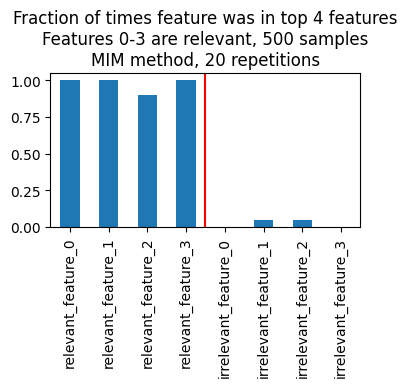

In [ ]:
plot_how_many_times_feature_in_top_k(create_artificial_dataset_1, "MIM", **plots_parameters)

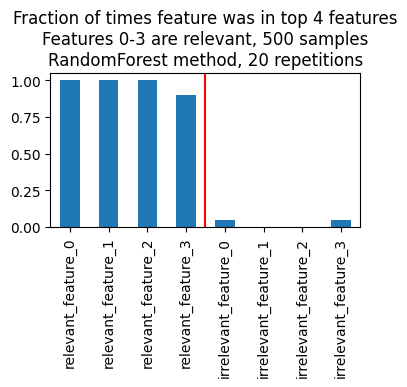

In [ ]:
plot_how_many_times_feature_in_top_k(create_artificial_dataset_1, "RandomForest", **plots_parameters)

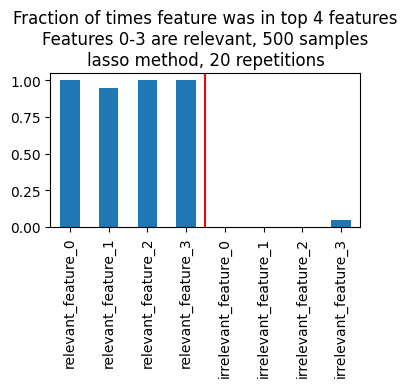

In [ ]:
plot_how_many_times_feature_in_top_k(create_artificial_dataset_1, "lasso", **plots_parameters)

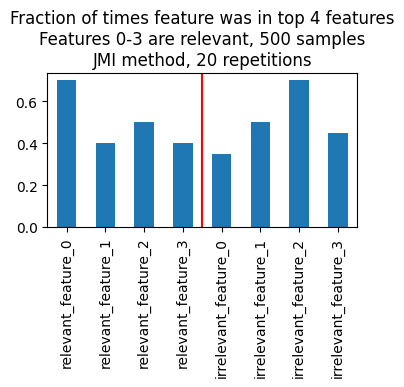

In [ ]:
plot_how_many_times_feature_in_top_k(create_artificial_dataset_1, "JMI", **plots_parameters)

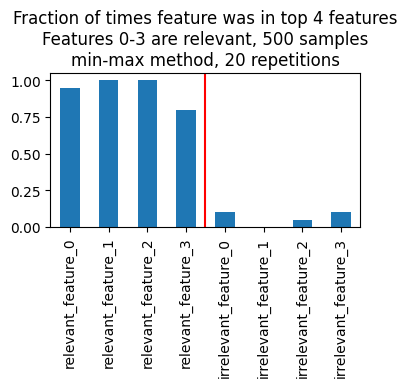

In [ ]:
plot_how_many_times_feature_in_top_k(create_artificial_dataset_1, "min-max", **plots_parameters)

Increasing number of samples generally helps. JMI needs much more samples than other methods.

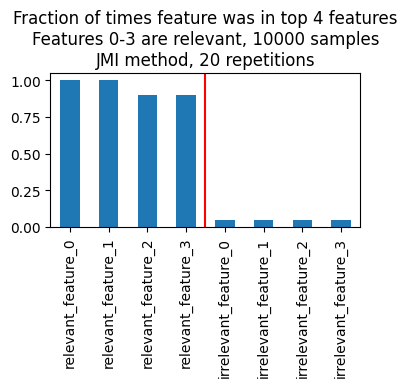

In [ ]:
plots_parameters['n_samples'] = 10000
plot_how_many_times_feature_in_top_k(create_artificial_dataset_1, "JMI", **plots_parameters)

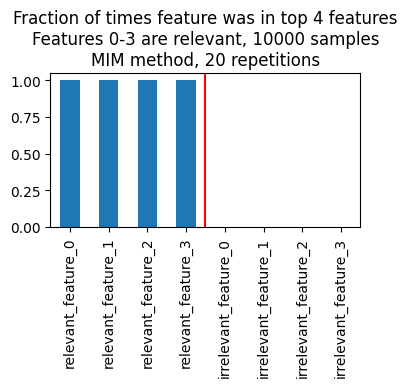

In [ ]:
plots_parameters['n_samples'] = 10000
plot_how_many_times_feature_in_top_k(create_artificial_dataset_1, "MIM", **plots_parameters)

### Artificial example in which one of the MI-based methods doesn’t work

Idea: duplicate columns. Then, the duplicates (highly correlated) are unnecessary and should not be selected.

### Creating data

In [14]:
def create_artificial_dataset_2(n=50):
    X_1 = np.random.normal(1, 1, n)
    X_2 = np.random.normal(1, 1, n)
    X_3 = np.random.choice([1,2], n)
    X_4 = np.random.normal(0, 0.25, n) + X_3
    y = (X_3) > 1.5
    X = np.vstack((X_1, X_2, X_3, X_4)).T
    X_artificial_2 = pd.DataFrame(X, columns=[f'X_{i+1}' for i in range(X.shape[1])])
    y_artificial_2 = pd.Series(y)

    discretize_artificial_2 = [True, True, False, True]
    return X_artificial_2, y_artificial_2, discretize_artificial_2

# example of feature importances for all features
X_artificial_2, y_artificial_2, discretize_artificial_2 = create_artificial_dataset_2(50)
print(mim_feature_selection(X_artificial_2, y_artificial_2, discretize_artificial_2, topk=20, debugging=True))
print(jmi_feature_selection(X_artificial_2, y_artificial_2, discretize_artificial_2, topk=20, debugging=True))
print(min_max_feature_selection(X_artificial_2, y_artificial_2, discretize_artificial_2, topk=20, debugging=True))

[('X_3', 0.6923469670899614), ('X_4', 0.6646210798675636), ('X_2', 0.0962894330478955), ('X_1', 0.0832775908390064)]
[('X_3', 0.6923469670899614), ('X_1', 0.6923469670899614), ('X_2', 1.754993630626397), ('X_4', 2.2531137706252227)]
[('X_3', 0.6923469670899614), ('X_1', 0.0), ('X_2', 0.0), ('X_4', 0.0)]


In [15]:
def plot_counts_each_feature(results_list, method_name, n_samples):
    # for each feature Xi separately, count how many times it was on each possible position
    features_names = sorted(results_list[0])
    feature_counts = {f: {i+1: 0 for i in range(len(results_list[0]))} for f in features_names}
    for i, result in enumerate(results_list):
        for j, feature in enumerate(result):
            feature_counts[feature][j+1] += 1
    feature_counts = pd.DataFrame(feature_counts).T / len(results_list)
    fig, ax = plt.subplots(figsize=(4, 3))
    feature_counts.plot(kind='bar', stacked=True, ax=ax, color = ['#5dcc66', '#dfe85c', '#f0b343', '#e84848'])
    plt.title(f"Counts of each feature on each position \nfor {method_name} method and {n_samples} samples")
    plt.show()

def plot_how_many_times_feature_in_top_k(create_dataset_with_discretization, method_name, dataset_sampling_times=100, n_samples=100):
    results = []
    for _ in range(dataset_sampling_times):
        X, y, discretization = create_dataset_with_discretization(n=n_samples)
        if method_name=='MIM':
            features_selected=mim_feature_selection(X, y, discretization, topk=20)
        elif method_name=='RandomForest':
            features_selected=random_forest_feature_selection(X, y, topk=20, debugging=False)
        elif method_name=="lasso":
            features_selected=lasso_regression_feature_selection(X, y, topk=20, debugging=False)
        elif method_name=="JMI":
            features_selected=jmi_feature_selection(X, y, discretization, topk=20)
        elif method_name == "min-max":
            features_selected=min_max_feature_selection(X, y, discretization, topk=20)
        else:
            print("Method not recognized")
            return
        results.append(features_selected)

    plot_counts_each_feature(results, method_name, n_samples)

### Plots

In [16]:
plots_parameters = {
    'dataset_sampling_times': 10,
    'n_samples': 100
}

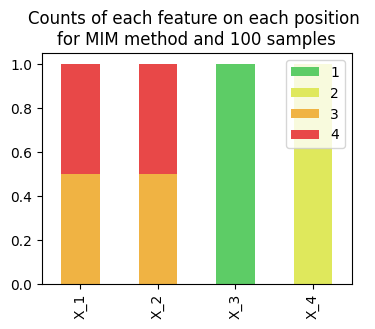

In [ ]:
plot_how_many_times_feature_in_top_k(create_artificial_dataset_2, "MIM", **plots_parameters)

In [ ]:
plot_how_many_times_feature_in_top_k(create_artificial_dataset_2, "RandomForest", **plots_parameters)

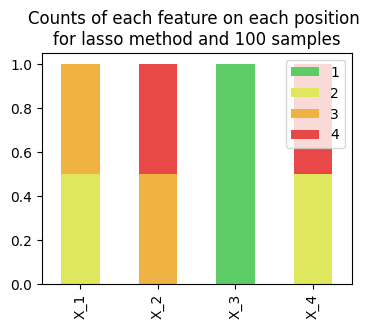

In [ ]:
plot_how_many_times_feature_in_top_k(create_artificial_dataset_2, "lasso", **plots_parameters)

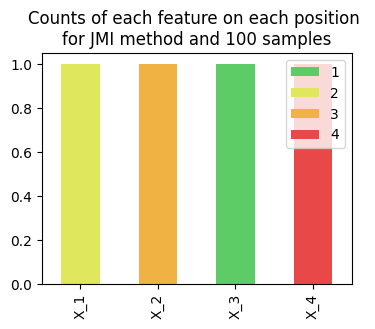

In [18]:
plot_how_many_times_feature_in_top_k(create_artificial_dataset_2, "JMI", **plots_parameters)

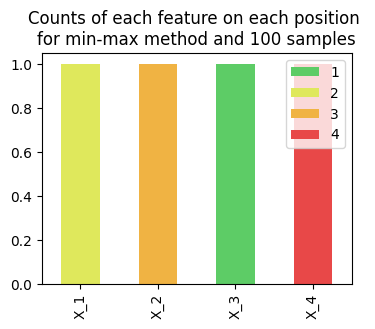

In [ ]:
plot_how_many_times_feature_in_top_k(create_artificial_dataset_2, "min-max", **plots_parameters)

Increasing the number of samples does not help.

In [ ]:
plots_parameters['n_samples'] = 10000
plot_how_many_times_feature_in_top_k(create_artificial_dataset_2, "MIM", **plots_parameters)

## real world datasets:


### Heart Disease

#### Loading data

In [ ]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X_heart_disease = heart_disease.data.features
y_heart_disease = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
pd.DataFrame(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2                                                None   None             no  
3   resting blood pressure (on admission to the ho...  mm Hg             no  
4                                   serum cholestoral  mg/dl             no  
5                     fasting blood sugar > 120 mg/dl   None             no  
6                                                None   None             no  
7                         maximum heart rate achieved   None             no  
8                             exercise induced angina   None             no  
9   ST depression induced by exercise relative to ...   None             no  
10                                               None   None             no  
11  number of major vessels (0-3) colored by flour...   None            yes  
12                                               None   None            yes  
13                         diagnosis of heart disease   None             no

In [ ]:
combined_heart=pd.concat([X_heart_disease, y_heart_disease], axis=1)
combined_heart_clean=combined_heart.dropna(how='any')
X_heart_disease_clean=combined_heart_clean.iloc[:, :len(X_heart_disease.columns)]
y_heart_disease_clean=combined_heart_clean.iloc[:, len(X_heart_disease.columns):]

In [ ]:
y_copy=y_heart_disease_clean.copy()
y_copy.loc[y_copy['num']>0, 'num']=1
y_heart_disease_clean=y_copy

In [ ]:
discretize_heart=[True for _ in range(len(X_heart_disease_clean.columns))]
discretize_heart

[True, True, True, True, True, True, True, True, True, True, True, True, True]

In [ ]:
model_heart = XGBClassifier
model_heart_params_dict = {
    'n_estimators': 7,
    'max_depth': 3,
    'random_state': 42
}

#### MIM

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
train_results: [0.7455038538395661, 0.7569226377390808, 0.83617613474165, 0.8538752497858978, 0.8659720239794462, 0.866364544675992, 0.8575149871538681, 0.8884884384813017, 0.8925206965458179, 0.896552954610334, 0.8917356551527262, 0.8873108763916643, 0.8873108763916643]
test_results: [0.8263888888888888, 0.7638888888888888, 0.8958333333333333, 0.8472222222222223, 0.8125, 0.8819444444444444, 0.8819444444444444, 0.8263888888888888, 0.8402777777777777, 0.8333333333333334, 0.8472222222222223, 0.8472222222222223, 0.8472222222222223]
train_results_all: 0.8873108763916643
test_re

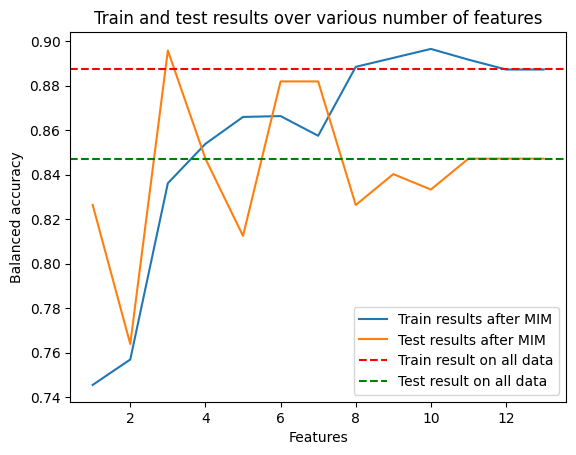

In [ ]:
run_all(X_heart_disease_clean, y_heart_disease_clean, model_heart, model_heart_params_dict, discretize_heart, "MIM", min_num_features=1, max_num_features=30)

#### JMI

In [ ]:
run_all(X_heart_disease_clean, y_heart_disease_clean, model_heart, model_heart_params_dict, discretize_heart, method_name="JMI", min_num_features=1, max_num_features=30)

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
train_results: [0.7455038538395661, 0.7817941764202112, 0.8006708535540965, 0.812375107051099, 0.8292891807022552, 0.8337139594633172, 0.8921281758492721, 0.8748215815015701, 0.8792463602626319, 0.8752141021981159, 0.9005852126748501, 0.8873108763916643, 0.8873108763916643]
test_results: [0.8263888888888888, 0.8333333333333333, 0.7569444444444444, 0.7847222222222223, 0.8402777777777777, 0.8194444444444444, 0.7986111111111112, 0.8611111111111112, 0.8611111111111112, 0.8611111111111112, 0.8472222222222223, 0.8472222222222223, 0.8472222222222223]
train_results_all: 0.887310876

#### CMIM

In [ ]:
run_all(X_heart_disease_clean, y_heart_disease_clean, model_heart, model_heart_params_dict, discretize_heart, method_name="min-max", min_num_features=1, max_num_features=30)

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
train_results: [0.7455038538395661, 0.7817941764202112, 0.8006708535540965, 0.8333214387667713, 0.84905795032829, 0.8502355124179275, 0.8502355124179275, 0.8538752497858978, 0.8792463602626319, 0.8961604339137882, 0.9005852126748501, 0.8873108763916643, 0.8873108763916643]
test_results: [0.8263888888888888, 0.8333333333333333, 0.7569444444444444, 0.7847222222222223, 0.8472222222222222, 0.8472222222222222, 0.8472222222222222, 0.875, 0.8611111111111112, 0.8333333333333334, 0.8472222222222223, 0.8472222222222223, 0.8472222222222223]
train_results_all: 0.8873108763916643
test_r

#### Random Forest

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
train_results: [0.7137453611190407, 0.7817941764202112, 0.8204396231801313, 0.8413859548958036, 0.8659720239794462, 0.8969454753068797, 0.8877033970882101, 0.8748215815015701, 0.8961604339137882, 0.8961604339137882, 0.8917356551527262, 0.8873108763916643, 0.8873108763916643]
test_results: [0.7222222222222223, 0.8333333333333333, 0.8125, 0.8958333333333333, 0.8125, 0.8125, 0.8472222222222223, 0.8611111111111112, 0.8541666666666667, 0.8541666666666667, 0.8472222222222223, 0.8472222222222223, 0.8472222222222223]
train_results_all: 0.8873108763916643
test_results_all: 0.8472222

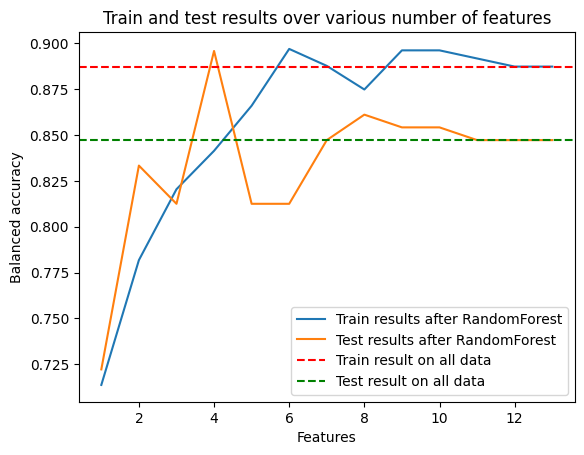

In [ ]:
run_all(X_heart_disease_clean, y_heart_disease_clean, model_heart, model_heart_params_dict, discretize_heart, method_name="RandomForest", min_num_features=1, max_num_features=30)

#### Lasso regression

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
train_results: [0.7560305452469311, 0.7794390522409363, 0.8034184984299172, 0.8030259777333714, 0.8337139594633172, 0.8469882957465029, 0.8546602911789895, 0.8804239223522694, 0.8804239223522694, 0.8623322866114759, 0.8756066228946617, 0.8877033970882101, 0.8873108763916643]
test_results: [0.6736111111111112, 0.7083333333333334, 0.7847222222222222, 0.7430555555555556, 0.7916666666666667, 0.875, 0.8541666666666667, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8194444444444444, 0.8472222222222223, 0.8472222222222223]
train_results_all: 0.8873108763916643
test

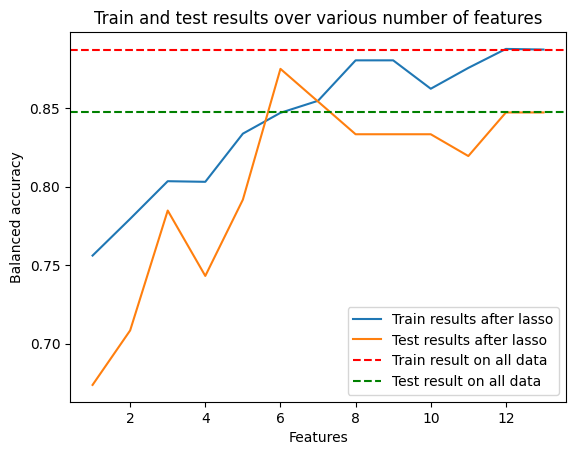

In [ ]:
run_all(X_heart_disease_clean, y_heart_disease_clean, model_heart, model_heart_params_dict, discretize_heart, method_name="lasso", min_num_features=1, max_num_features=30)

### Wine


#### Loading data

In [ ]:
# fetch dataset
wine = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X_wine = wine.data.features
y_wine = wine.data.targets

# metadata
print(wine.metadata)

# variable information
pd.DataFrame(wine.variables)

{'uci_id': 109, 'name': 'Wine', 'repository_url': 'https://archive.ics.uci.edu/dataset/109/wine', 'data_url': 'https://archive.ics.uci.edu/static/public/109/data.csv', 'abstract': 'Using chemical analysis to determine the origin of wines', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 178, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1992, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C5PC7J', 'creators': ['Stefan Aeberhard', 'M. Forina'], 'intro_paper': {'title': 'Comparative analysis of statistical pattern recognition methods in high dimensional settings', 'authors': 'S. Aeberhard, D. Coomans, O. Vel', 'published_in': 'Pattern Recognition', 'year': 1994, 'url': 'https://www.semanticscholar.org/paper/83dc3e4030d7b9fbdbb4bde03ce12ab70ca10528', 'do

name     role         type demographic  \
0                          class   Target  Categorical        None   
1                        Alcohol  Feature   Continuous        None   
2                      Malicacid  Feature   Continuous        None   
3                            Ash  Feature   Continuous        None   
4              Alcalinity_of_ash  Feature   Continuous        None   
5                      Magnesium  Feature      Integer        None   
6                  Total_phenols  Feature   Continuous        None   
7                     Flavanoids  Feature   Continuous        None   
8           Nonflavanoid_phenols  Feature   Continuous        None   
9                Proanthocyanins  Feature   Continuous        None   
10               Color_intensity  Feature   Continuous        None   
11                           Hue  Feature   Continuous        None   
12  0D280_0D315_of_diluted_wines  Feature   Continuous        None   
13                       Proline  Feature      Integer        None   

   description units missing_values  
0         None  None             no  
1         None  None             no  
2         None  None             no  
3         None  None             no  
4         None  None             no  
5         None  None             no  
6         None  None             no  
7         None  None             no  
8         None  None             no  
9         None  None             no  
10        None  None             no  
11        None  None             no  
12        None  None             no  
13        None  None             no

In [ ]:
y_copy=y_wine.copy()
y_copy.loc[y_copy['class']==1, 'class']=0
y_copy.loc[y_copy['class']==2, 'class']=1
y_copy.loc[y_copy['class']==3, 'class']=2
y_wine=y_copy

In [ ]:
discretize_wine=[True for _ in range(len(X_wine.columns))]
discretize_wine

[True, True, True, True, True, True, True, True, True, True, True, True, True]

In [ ]:
model_wine = XGBClassifier
model_wine_params_dict = {
    'n_estimators': 2,
    'max_depth': 2,
    'random_state': 42
}

#### MIM

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
train_results: [0.8456627680311891, 0.8873294346978557, 0.9559454191033138, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9676413255360624]
test_results: [0.8154761904761906, 0.7083333333333334, 0.8511904761904763, 0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.9523809523809524, 0.9523809523809524, 0.9523809523809524, 0.9523809523809524, 0.9523809523809524, 0.9761904761904763]
train_results_all: 0.96764132

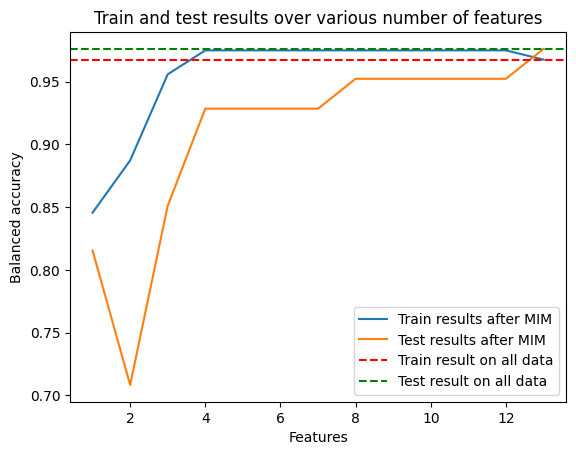

In [ ]:
run_all(X_wine, y_wine, model_wine, model_wine_params_dict, discretize_wine, "MIM", min_num_features=1, max_num_features=30)

#### JMI

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
train_results: [0.8456627680311891, 0.8456627680311891, 0.8456627680311891, 0.8456627680311891, 0.882504873294347, 0.9374756335282651, 0.9374756335282651, 0.9374756335282651, 0.9624269005847953, 0.9766081871345028, 0.9707602339181287, 0.9707602339181287, 0.9676413255360624]
test_results: [0.8154761904761906, 0.8154761904761906, 0.8154761904761906, 0.8392857142857143, 0.8869047619047619, 0.8869047619047619, 0.8869047619047619, 0.8630952380952381, 0.9345238095238096, 0.9107142857142857, 0.9523809523809524, 0.9523809523809524, 0.9761904761904763]
train_results_all: 0.967641325

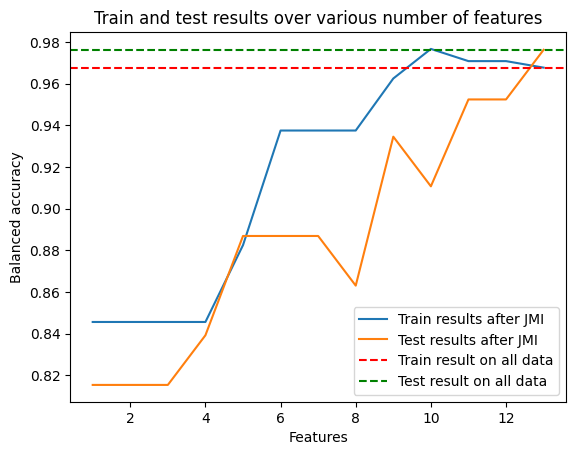

In [ ]:
run_all(X_wine, y_wine, model_wine, model_wine_params_dict, discretize_wine, method_name="JMI", min_num_features=1, max_num_features=30)

#### CMIM

In [ ]:
run_all(X_wine, y_wine, model_wine, model_wine_params_dict, discretize_wine, method_name="min-max", min_num_features=1, max_num_features=30)

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
train_results: [0.8456627680311891, 0.8456627680311891, 0.8873294346978557, 0.8873294346978557, 0.9192982456140352, 0.9516569200779728, 0.9516569200779728, 0.9824561403508771, 0.9824561403508771, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9676413255360624]
test_results: [0.8154761904761906, 0.8154761904761906, 0.7083333333333334, 0.7083333333333334, 0.7738095238095237, 0.8035714285714285, 0.8452380952380952, 0.9523809523809524, 0.9523809523809524, 0.9523809523809524, 0.9523809523809524, 0.9523809523809524, 0.9761904761904763]
train_results_all: 0.96764132

#### RandomForest

In [ ]:
run_all(X_wine, y_wine, model_wine, model_wine_params_dict, discretize_wine, method_name="RandomForest", min_num_features=1, max_num_features=30)

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
train_results: [0.8456627680311891, 0.9707602339181287, 0.9883040935672515, 0.980896686159844, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9750487329434697, 0.9676413255360624, 0.9676413255360624]
test_results: [0.8154761904761906, 0.8869047619047619, 0.9345238095238096, 0.8869047619047619, 0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.9523809523809524, 0.9523809523809524, 0.9523809523809524, 0.9523809523809524, 0.9761904761904763, 0.9761904761904763]
train_results_all: 0.967641325

#### Lasso regression

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
train_results: [0.8456627680311891, 0.8873294346978557, 0.8873294346978557, 0.8990253411306043, 0.8990253411306043, 0.9282651072124756, 0.9565789473684211, 0.9766081871345028, 0.9766081871345028, 0.9766081871345028, 0.9766081871345028, 0.9676413255360624, 0.9676413255360624]
test_results: [0.8154761904761906, 0.7083333333333334, 0.7083333333333334, 0.7321428571428572, 0.7321428571428572, 0.7738095238095238, 0.9761904761904763, 0.9761904761904763, 0.9761904761904763, 0.9761904761904763, 0.9761904761904763, 0.9761904761904763, 0.9761904761904763]
train_results_all: 0.96764132

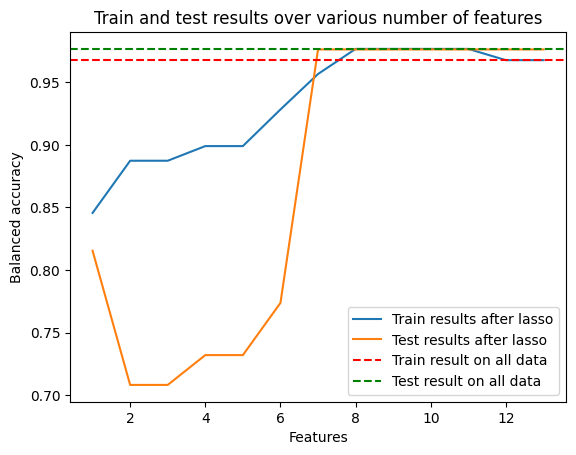

In [ ]:
run_all(X_wine, y_wine, model_wine, model_wine_params_dict, discretize_wine, method_name="lasso", min_num_features=1, max_num_features=30)

### Predict Students Dropout and Academic Success

#### Loading data

In [ ]:
# fetch dataset
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes)
X_students = predict_students_dropout_and_academic_success.data.features
y_students = predict_students_dropout_and_academic_success.data.targets

# metadata
print(predict_students_dropout_and_academic_success.metadata)

# variable information
pd.DataFrame(predict_students_dropout_and_academic_success.variables)

{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

name     role         type  \
0                                   Marital Status  Feature      Integer   
1                                 Application mode  Feature      Integer   
2                                Application order  Feature      Integer   
3                                           Course  Feature      Integer   
4                       Daytime/evening attendance  Feature      Integer   
5                           Previous qualification  Feature      Integer   
6                   Previous qualification (grade)  Feature   Continuous   
7                                      Nacionality  Feature      Integer   
8                           Mother's qualification  Feature      Integer   
9                           Father's qualification  Feature      Integer   
10                             Mother's occupation  Feature      Integer   
11                             Father's occupation  Feature      Integer   
12                                 Admission grade  Feature   Continuous   
13                                       Displaced  Feature      Integer   
14                       Educational special needs  Feature      Integer   
15                                          Debtor  Feature      Integer   
16                         Tuition fees up to date  Feature      Integer   
17                                          Gender  Feature      Integer   
18                              Scholarship holder  Feature      Integer   
19                               Age at enrollment  Feature      Integer   
20                                   International  Feature      Integer   
21             Curricular units 1st sem (credited)  Feature      Integer   
22             Curricular units 1st sem (enrolled)  Feature      Integer   
23          Curricular units 1st sem (evaluations)  Feature      Integer   
24             Curricular units 1st sem (approved)  Feature      Integer   
25                Curricular units 1st sem (grade)  Feature      Integer   
26  Curricular units 1st sem (without evaluations)  Feature      Integer   
27             Curricular units 2nd sem (credited)  Feature      Integer   
28             Curricular units 2nd sem (enrolled)  Feature      Integer   
29          Curricular units 2nd sem (evaluations)  Feature      Integer   
30             Curricular units 2nd sem (approved)  Feature      Integer   
31                Curricular units 2nd sem (grade)  Feature      Integer   
32  Curricular units 2nd sem (without evaluations)  Feature      Integer   
33                               Unemployment rate  Feature   Continuous   
34                                  Inflation rate  Feature   Continuous   
35                                             GDP  Feature   Continuous   
36                                          Target   Target  Categorical   

        demographic                                        description units  \
0    Marital Status  1 – single 2 – married 3 – widower 4 – divorce...  None   
1              None  1 - 1st phase - general contingent 2 - Ordinan...  None   
2              None  Application order (between 0 - first choice; a...  None   
3              None  33 - Biofuel Production Technologies 171 - Ani...  None   
4              None                            1 – daytime 0 - evening  None   
5   Education Level  1 - Secondary education 2 - Higher education -...  None   
6              None  Grade of previous qualification (between 0 and...  None   
7       Nationality  1 - Portuguese; 2 - German; 6 - Spanish; 11 - ...  None   
8   Education Level  1 - Secondary Education - 12th Year of Schooli...  None   
9   Education Level  1 - Secondary Education - 12th Year of Schooli...  None   
10       Occupation  0 - Student 1 - Representatives of the Legisla...  None   
11       Occupation  0 - Student 1 - Representatives of the Legisla...  None   
12             None                Admission grade (between 0 and 200)  None   
13             None                  

In [ ]:
y_copy=y_students.copy()
y_copy.loc[y_copy['Target']=='Dropout', 'Target']=0
y_copy.loc[y_copy['Target']=='Enrolled', 'Target']=1
y_copy.loc[y_copy['Target']=='Graduate', 'Target']=2
y_students=y_copy
y_students['Target']=y_students['Target'].astype(int)

In [ ]:
discretize_students=[True for _ in range(len(X_students.columns))]
discretize_students

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [ ]:
model_students = XGBClassifier
model_students_params_dict = {
    'n_estimators': 18,
    'max_depth': 3,
    'random_state': 42
}

#### MIM

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
current num features checked: 22
current num features checked: 23
current num features checked: 24
current num features checked: 25
current num features checked: 26
current num features checked: 27
current num features checked: 28
current num features checked: 29
current num features checked: 30
current num feature

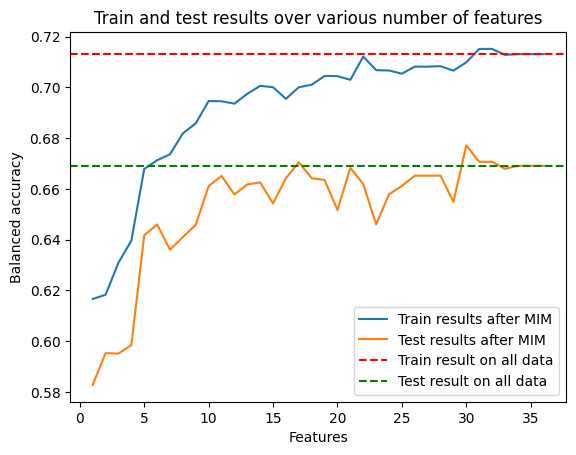

In [ ]:
run_all(X_students, y_students, model_students, model_students_params_dict, discretize_students, "MIM", min_num_features=1, max_num_features=36)

#### JMI

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
current num features checked: 22
current num features checked: 23
current num features checked: 24
current num features checked: 25
current num features checked: 26
current num features checked: 27
current num features checked: 28
current num features checked: 29
current num features checked: 30
current num feature

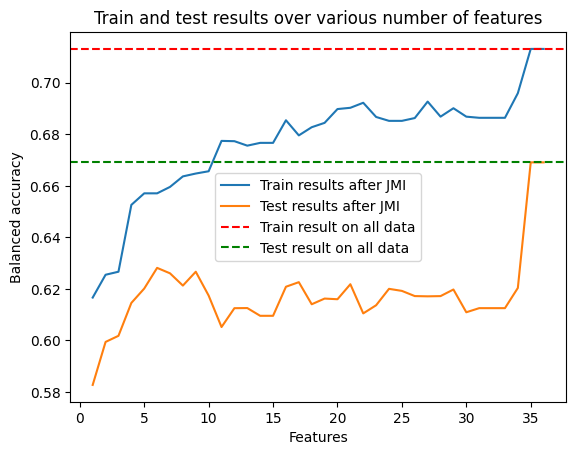

In [ ]:
run_all(X_students, y_students, model_students, model_students_params_dict, discretize_students, method_name="JMI", min_num_features=1, max_num_features=36)

#### CMIM

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
current num features checked: 22
current num features checked: 23
current num features checked: 24
current num features checked: 25
current num features checked: 26
current num features checked: 27
current num features checked: 28
current num features checked: 29
current num features checked: 30
current num feature

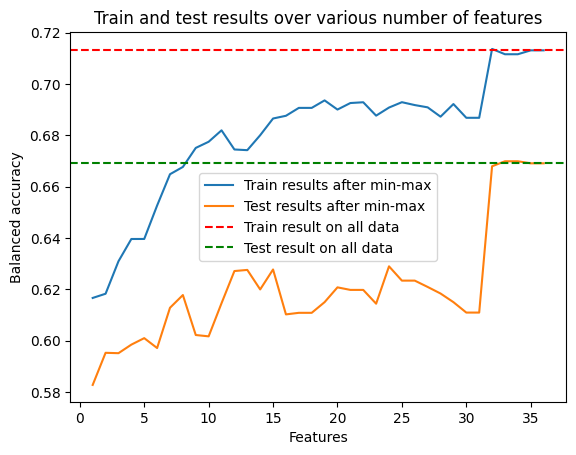

In [ ]:
run_all(X_students, y_students, model_students, model_students_params_dict, discretize_students, method_name="min-max", min_num_features=1, max_num_features=36)

#### RandomForest

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
current num features checked: 22
current num features checked: 23
current num features checked: 24
current num features checked: 25
current num features checked: 26
current num features checked: 27
current num features checked: 28
current num features checked: 29
current num features checked: 30
current num feature

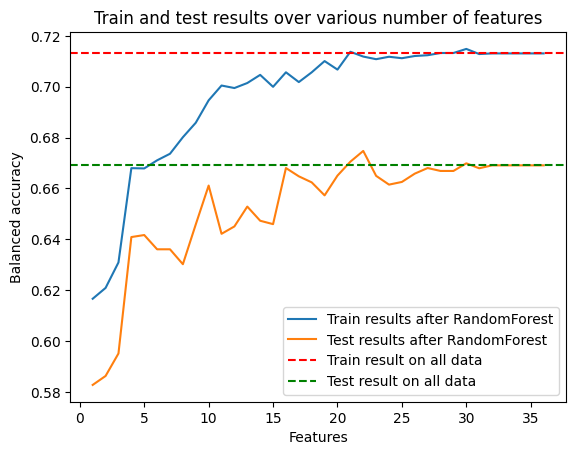

In [ ]:
run_all(X_students, y_students, model_students, model_students_params_dict, discretize_students, method_name="RandomForest", min_num_features=1, max_num_features=36)

#### Lasso regression

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
current num features checked: 22
current num features checked: 23
current num features checked: 24
current num features checked: 25
current num features checked: 26
current num features checked: 27
current num features checked: 28
current num features checked: 29
current num features checked: 30
current num feature

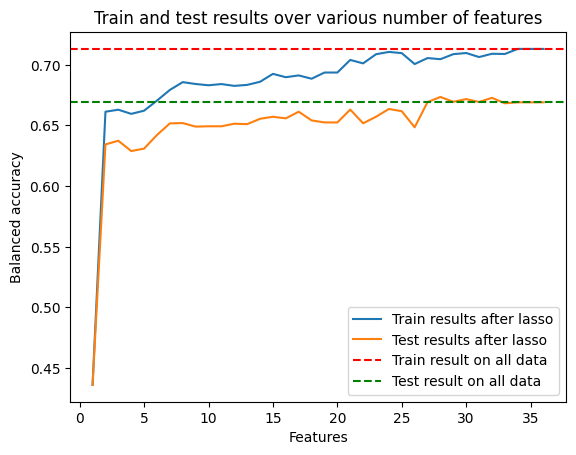

In [ ]:
run_all(X_students, y_students, model_students, model_students_params_dict, discretize_students, method_name="lasso", min_num_features=1, max_num_features=36)

### CDC Diabetes Health Indicators

#### Loading data

In [ ]:
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X_diabetes = cdc_diabetes_health_indicators.data.features
y_diabetes = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
pd.DataFrame(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

name     role     type      demographic  \
0                     ID       ID  Integer             None   
1        Diabetes_binary   Target   Binary             None   
2                 HighBP  Feature   Binary             None   
3               HighChol  Feature   Binary             None   
4              CholCheck  Feature   Binary             None   
5                    BMI  Feature  Integer             None   
6                 Smoker  Feature   Binary             None   
7                 Stroke  Feature   Binary             None   
8   HeartDiseaseorAttack  Feature   Binary             None   
9           PhysActivity  Feature   Binary             None   
10                Fruits  Feature   Binary             None   
11               Veggies  Feature   Binary             None   
12     HvyAlcoholConsump  Feature   Binary             None   
13         AnyHealthcare  Feature   Binary             None   
14           NoDocbcCost  Feature   Binary             None   
15               GenHlth  Feature  Integer             None   
16              MentHlth  Feature  Integer             None   
17              PhysHlth  Feature  Integer             None   
18              DiffWalk  Feature   Binary             None   
19                   Sex  Feature   Binary              Sex   
20                   Age  Feature  Integer              Age   
21             Education  Feature  Integer  Education Level   
22                Income  Feature  Integer           Income   

                                          description units missing_values  
0                                          Patient ID  None             no  
1         0 = no diabetes 1 = prediabetes or diabetes  None             no  
2                          0 = no high BP 1 = high BP  None             no  
3        0 = no high cholesterol 1 = high cholesterol  None             no  
4   0 = no cholesterol check in 5 years 1 = yes ch...  None             no  
5                                     Body Mass Index  None             no  
6   Have you smoked at least 100 cigarettes in you...  None             no  
7        (Ever told) you had a stroke. 0 = no 1 = yes  None             no  
8   coronary heart disease (CHD) or myocardial inf...  None             no  
9   physical activity in past 30 days - not includ...  None             no  
10  Consume Fruit 1 or more times per day 0 = no 1...  None             no  
11  Consume Vegetables 1 or more times per day 0 =...  None             no  
12  Heavy drinkers (adult men having more than 14 ...  None             no  
13  Have any kind of health care coverage, includi...  None             no  
14  Was there a time in the past 12 months when yo...  None             no  
15  Would you say that in general your health is: ...  None             no  
16  Now thinking about your mental health, which i...  None             no  
17  Now thinking about your physical health, which...  None             no  
18  Do you have serious difficulty walking or clim...  None             no  
19                                0 = female 1 = male  None             no  
20  13-level age category (_AGEG5YR see codebook) ...  None             no  
21  Education level (EDUCA see codebook) scale 1-6...  None             no  
22  Income scale (INCOME2 see codebook) scale 1-8 ...  None             no

In [ ]:
discretize_diabetes=[True for _ in range(len(X_diabetes.columns))]
discretize_diabetes

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [ ]:
model_diabetes = XGBClassifier
model_diabetes_params_dict = {
    'n_estimators': 20,
    'max_depth': 8,
    'random_state': 12
}

In [ ]:
y_diabetes.value_counts()

Diabetes_binary
0                  218334
1                   35346
Name: count, dtype: int64

#### MIM

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
train_results: [0.5, 0.5, 0.5492825469124293, 0.5568907272247584, 0.5571415583205083, 0.5639479232159311, 0.5681568335734422, 0.5700557040979963, 0.5745376296955835, 0.5751559327752532, 0.5763311787460258, 0.5768657064637359, 0.5760468917725732, 0.5774249630801258, 0.5776579332147216, 0.5804921310252488, 0.57914219

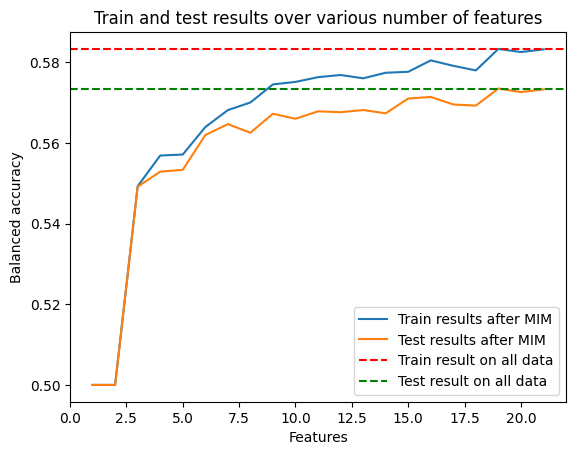

In [ ]:
run_all(X_diabetes, y_diabetes, model_diabetes, model_diabetes_params_dict, discretize_diabetes, "MIM", min_num_features=1, max_num_features=30)

#### JMI

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
train_results: [0.5, 0.5007620416468309, 0.5022371218269229, 0.5059061839289513, 0.5080259791548484, 0.5091104461584331, 0.5110651877340828, 0.5115444421265325, 0.5250156738371687, 0.5354601017242495, 0.5490706131511719, 0.5776125198907869, 0.5771378123362331, 0.5781900041650995, 0.5795248952613263, 0.5785820693799

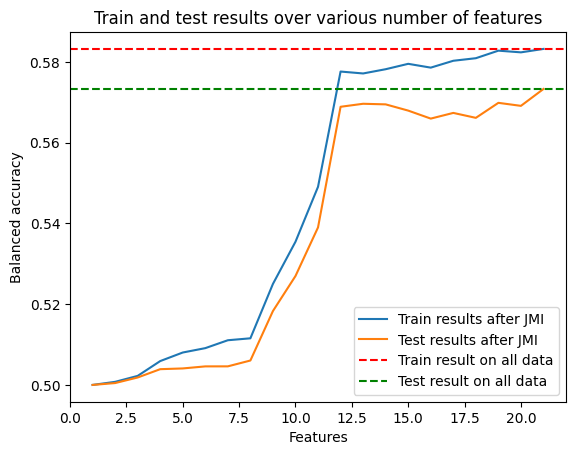

In [ ]:
run_all(X_diabetes, y_diabetes, model_diabetes, model_diabetes_params_dict, discretize_diabetes, method_name="JMI", min_num_features=1, max_num_features=30)

#### CMIM

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
train_results: [0.5, 0.5, 0.5, 0.5182871331081016, 0.5201476415946311, 0.5222453003568835, 0.529003483519295, 0.5300498121395786, 0.5309637692874406, 0.5326432698847477, 0.5351664974202817, 0.5458506680181203, 0.5478132272052139, 0.5489839263380905, 0.5756523221096621, 0.5750736094516834, 0.5747870490592828, 0.5758

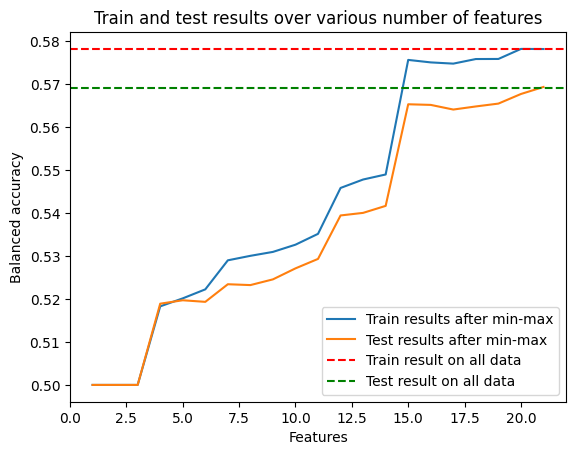

In [ ]:
run_all(X_diabetes, y_diabetes, model_diabetes, model_diabetes_params_dict, discretize_diabetes, method_name="min-max", min_num_features=1, max_num_features=30)

#### RandomForest

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
train_results: [0.5, 0.5, 0.5400277241546609, 0.5590049379518206, 0.5484654959014004, 0.557107281062247, 0.5653033630697104, 0.566575474870977, 0.5677694911704827, 0.57109153468478, 0.570963893398639, 0.5727363510207183, 0.5739653705976799, 0.5726169820298107, 0.5740085105026667, 0.5754119487410729, 0.5755736839370

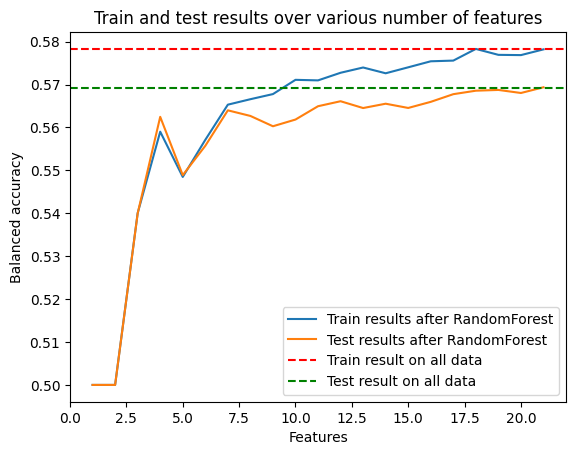

In [ ]:
run_all(X_diabetes, y_diabetes, model_diabetes, model_diabetes_params_dict, discretize_diabetes, method_name="RandomForest", min_num_features=1, max_num_features=30)

#### Lasso regression

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
train_results: [0.5, 0.5102842400908161, 0.5400277241546609, 0.5505292917828424, 0.5545470555400572, 0.5590480228017829, 0.564244989016174, 0.5662175035659569, 0.5651090336828872, 0.5691049323118627, 0.568579993260073, 0.5704926876466994, 0.5710199881044579, 0.5745079469559001, 0.5757890167652561, 0.575259897572339

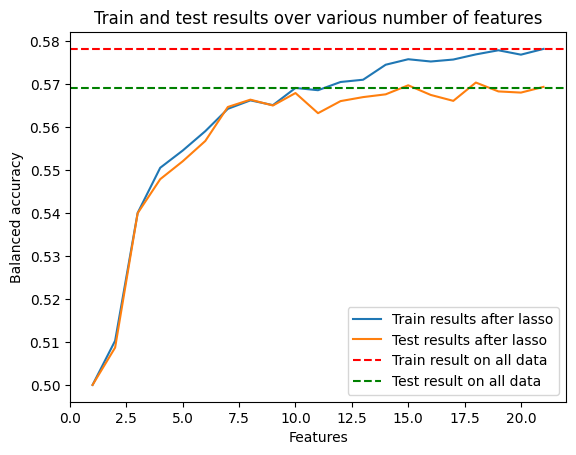

In [ ]:
run_all(X_diabetes, y_diabetes, model_diabetes, model_diabetes_params_dict, discretize_diabetes, method_name="lasso", min_num_features=1, max_num_features=30)

### Phishing Websites

#### Loading data

In [ ]:
# fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
X_phishing = phishing_websites.data.features
y_phishing = phishing_websites.data.targets

# metadata
print(phishing_websites.metadata)

# variable information
pd.DataFrame(phishing_websites.variables)

{'uci_id': 327, 'name': 'Phishing Websites', 'repository_url': 'https://archive.ics.uci.edu/dataset/327/phishing+websites', 'data_url': 'https://archive.ics.uci.edu/static/public/327/data.csv', 'abstract': 'This dataset collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 11055, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['result'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Tue Mar 05 2024', 'dataset_doi': '10.24432/C51W2X', 'creators': ['Rami Mohammad', 'Lee McCluskey'], 'intro_paper': {'title': 'An assessment of features related to phishing websites using an automated technique', 'authors': 'R. Mohammad, F. Thabtah, L. Mccluskey', 'published_in': 'International Conference for Internet Technology and Secured Tr

name     role     type demographic description  \
0            having_ip_address  Feature  Integer        None        None   
1                   url_length  Feature  Integer        None        None   
2           shortining_service  Feature  Integer        None        None   
3             having_at_symbol  Feature  Integer        None        None   
4     double_slash_redirecting  Feature  Integer        None        None   
5                prefix_suffix  Feature  Integer        None        None   
6            having_sub_domain  Feature  Integer        None        None   
7               sslfinal_state  Feature  Integer        None        None   
8   domain_registration_length  Feature  Integer        None        None   
9                      favicon  Feature  Integer        None        None   
10                        port  Feature  Integer        None        None   
11                 https_token  Feature  Integer        None        None   
12                 request_url  Feature  Integer        None        None   
13               url_of_anchor  Feature  Integer        None        None   
14               links_in_tags  Feature  Integer        None        None   
15                         sfh  Feature  Integer        None        None   
16         submitting_to_email  Feature  Integer        None        None   
17                abnormal_url  Feature  Integer        None        None   
18                    redirect  Feature  Integer        None        None   
19                on_mouseover  Feature  Integer        None        None   
20                  rightclick  Feature  Integer        None        None   
21                 popupwindow  Feature  Integer        None        None   
22                      iframe  Feature  Integer        None        None   
23               age_of_domain  Feature  Integer        None        None   
24                   dnsrecord  Feature  Integer        None        None   
25                 web_traffic  Feature  Integer        None        None   
26                   page_rank  Feature  Integer        None        None   
27                google_index  Feature  Integer        None        None   
28      links_pointing_to_page  Feature  Integer        None        None   
29          statistical_report  Feature  Integer        None        None   
30                      result   Target  Integer        None        None   

   units missing_values  
0   None             no  
1   None             no  
2   None             no  
3   None             no  
4   None             no  
5   None             no  
6   None             no  
7   None             no  
8   None             no  
9   None             no  
10  None             no  
11  None             no  
12  None             no  
13  None             no  
14  None             no  
15  None             no  
16  None             no  
17  None             no  
18  None             no  
19  None             no  
20  None             no  
21  None             no  
22  None             no  
23  None             no  
24  None             no  
25  None             no  
26  None             no  
27  None             no  
28  None             no  
29  None             no  
30  None             no

In [ ]:
y_copy=y_phishing.copy()
y_copy.loc[y_copy['result']==-1, 'result']=0
y_phishing=y_copy

In [ ]:
discretize_phishing=[True for _ in range(len(X_phishing.columns))]
discretize_phishing

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [ ]:
model_phishing = XGBClassifier
model_phishing_params_dict = {
    'n_estimators': 10,
    'max_depth': 5,
    'random_state': 42
}

#### MIM

In [ ]:
run_all(X_phishing, y_phishing, model_phishing, model_phishing_params_dict, discretize_phishing, "MIM", min_num_features=1, max_num_features=30)

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
current num features checked: 22
current num features checked: 23
current num features checked: 24
current num features checked: 25
current num features checked: 26
current num features checked: 27
current num features checked: 28
current num features checked: 29
current num features checked: 30
train_results: [0.8

#### JMI

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
current num features checked: 22
current num features checked: 23
current num features checked: 24
current num features checked: 25
current num features checked: 26
current num features checked: 27
current num features checked: 28
current num features checked: 29
current num features checked: 30
train_results: [0.8

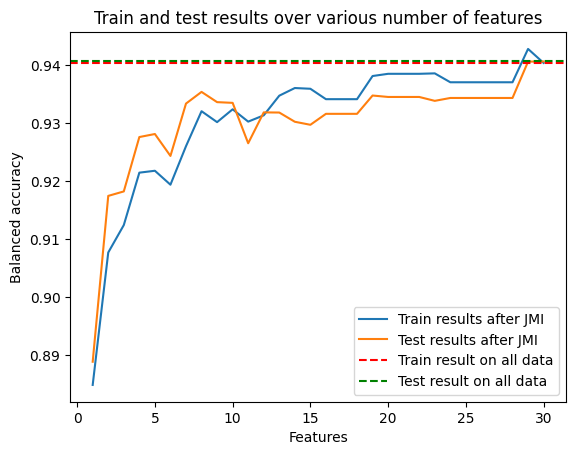

In [ ]:
run_all(X_phishing, y_phishing, model_phishing, model_phishing_params_dict, discretize_phishing, method_name="JMI", min_num_features=1, max_num_features=30)

#### CMIM

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
current num features checked: 22
current num features checked: 23
current num features checked: 24
current num features checked: 25
current num features checked: 26
current num features checked: 27
current num features checked: 28
current num features checked: 29
current num features checked: 30
train_results: [0.8

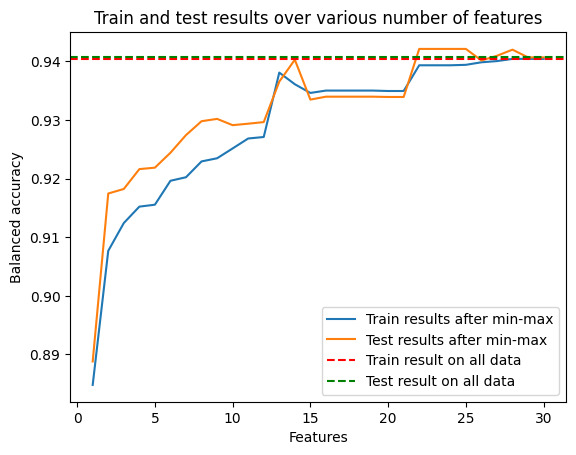

In [ ]:
run_all(X_phishing, y_phishing, model_phishing, model_phishing_params_dict, discretize_phishing, method_name="min-max", min_num_features=1, max_num_features=30)

#### RandomForest

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
current num features checked: 22
current num features checked: 23
current num features checked: 24
current num features checked: 25
current num features checked: 26
current num features checked: 27
current num features checked: 28
current num features checked: 29
current num features checked: 30
train_results: [0.8

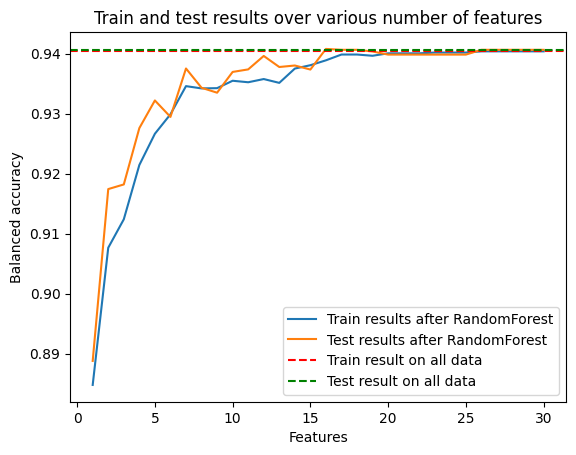

In [ ]:
run_all(X_phishing, y_phishing, model_phishing, model_phishing_params_dict, discretize_phishing, method_name="RandomForest", min_num_features=1, max_num_features=30)

#### Lasso Regression

In [ ]:
run_all(X_phishing, y_phishing, model_phishing, model_phishing_params_dict, discretize_phishing, method_name="lasso", min_num_features=1, max_num_features=30)

current num features checked: 1
current num features checked: 2
current num features checked: 3
current num features checked: 4
current num features checked: 5
current num features checked: 6
current num features checked: 7
current num features checked: 8
current num features checked: 9
current num features checked: 10
current num features checked: 11
current num features checked: 12
current num features checked: 13
current num features checked: 14
current num features checked: 15
current num features checked: 16
current num features checked: 17
current num features checked: 18
current num features checked: 19
current num features checked: 20
current num features checked: 21
current num features checked: 22
current num features checked: 23
current num features checked: 24
current num features checked: 25
current num features checked: 26
current num features checked: 27
current num features checked: 28
current num features checked: 29
current num features checked: 30
train_results: [0.8